Student name: Sicheng Mao

## import data

In [1]:
# import numpy as np
import pandas as pd

In [2]:
# Load the data, will be transformed into a stream later
df = pd.read_csv("./data/covtype.data", header=None)
label_col = df.columns[-1]
feature_cols = list(df.columns)
feature_cols.pop()
X = df[feature_cols]
Y = df[label_col]

In [3]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


In [4]:
df.shape

(581012, 55)

## import classifiers

In [5]:
from river.tree import HoeffdingTreeClassifier
from river.neighbors import KNNClassifier
from river.linear_model import LogisticRegression
from river.naive_bayes import GaussianNB
from river.multiclass import OneVsOneClassifier,OneVsRestClassifier
from river.stream import iter_pandas
from river import metrics, utils
import time

### verify if support multiclassification

In [6]:
lr_ovo = OneVsOneClassifier(LogisticRegression())
lr_ovr = OneVsRestClassifier(LogisticRegression())
nb = GaussianNB()
knn = KNNClassifier(n_neighbors=5, window_size=50)
ht = HoeffdingTreeClassifier()

LogisticRegression and SGTClassifier are not multiclassification methods, but never mind we can change them into so.

In [7]:
all = [lr_ovo, lr_ovr, nb, knn, ht]
[clf._multiclass for clf in all]

[True, True, True, True, True]

In [8]:
from tqdm import tqdm

def print_progress(sample_id, acc, kappa):
    print(f'Samples processed: {sample_id}')
    print(acc)
    print(kappa)

def evaluate(stream, model, n_wait=10000, verbose=False):
    acc = metrics.Accuracy()
    acc_rolling = utils.Rolling(metrics.Accuracy(), window_size=n_wait)
    kappa = metrics.CohenKappa()
    kappa_rolling = utils.Rolling(metrics.CohenKappa(), window_size=n_wait)
    raw_results = []
    model_name = model.__class__.__name__
    start_time = time.time()
    for i, (x, y) in tqdm(enumerate(stream), total=len(df)):
        # Predict
        y_pred = model.predict_one(x)
        # Update metrics and results
        acc.update(y_true=y, y_pred=y_pred)
        acc_rolling.update(y_true=y, y_pred=y_pred)
        kappa.update(y_true=y, y_pred=y_pred)
        kappa_rolling.update(y_true=y, y_pred=y_pred)
        if i % n_wait == 0 and i > 0:
            if verbose:
                print_progress(i, acc, kappa)
            raw_results.append([model_name, i, acc.get(), acc_rolling.get(), kappa.get(), kappa_rolling.get(), time.time()-start_time])
        # Learn (train)
        model.learn_one(x, y)
    print_progress(i, acc, kappa)
    return pd.DataFrame(raw_results, columns=['model', 'id', 'acc', 'acc_roll', 'kappa', 'kappa_roll', 'time'])


In [ ]:
results = [evaluate(stream=iter_pandas(X,Y), model=cls) for cls in all]

  0%|          | 63/581012 [00:00<15:50, 610.95it/s]

Samples processed: 581011
Accuracy: 48.77%
CohenKappa: 0.04%


  0%|          | 29/581012 [00:00<33:40, 287.48it/s]

Samples processed: 581011
Accuracy: 95.01%
CohenKappa: 91.99%


100%|██████████| 581012/581012 [14:47<00:00, 654.75it/s] 

Samples processed: 581011
Accuracy: 76.07%
CohenKappa: 60.99%


In [11]:
import pickle
with open("results", "wb") as fp:   #Pickling
    pickle.dump(results, fp)

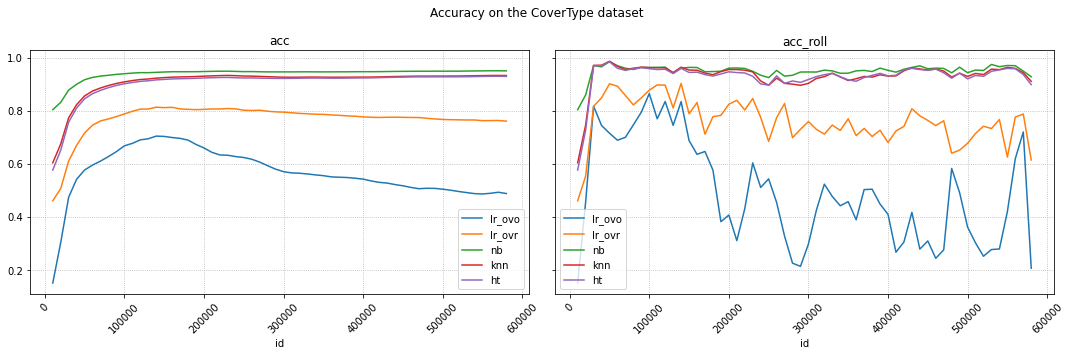

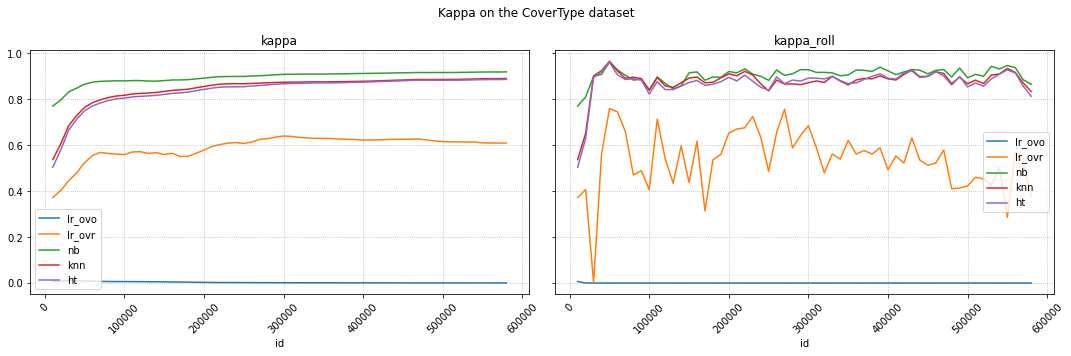

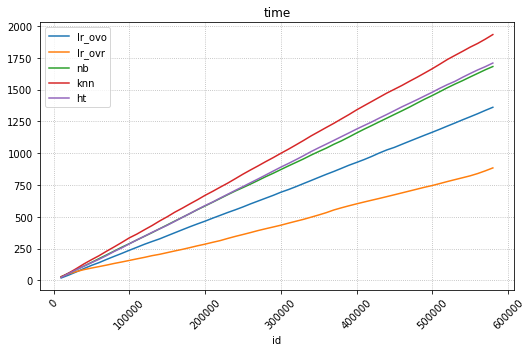

In [25]:
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

dataset = "CoverType"

df = pd.concat(results)
legend = ['lr_ovo','lr_ovr','nb','knn','ht']
# df = ht_results.copy()
df.set_index('id', inplace=True)
grouped = df.groupby('model')

with PdfPages(f'results_{dataset}.pdf') as pdf:
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['acc', 'acc_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(legend, loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Accuracy on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5), sharey=True)
    for metric, ax in zip(['kappa', 'kappa_roll'], axes.flatten()):
        grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
        ax.legend(legend, loc='best')
        ax.grid(linestyle=':')
    fig.suptitle("Kappa on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page

    fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(7.5,5))
    metric = 'time'
    grouped[metric].plot(rot=45, title=metric, legend=True, ax=ax)
    ax.legend(legend, loc='best')
    ax.grid(linestyle=':')
    # fig.suptitle("Time on the %s dataset" % dataset)
    plt.tight_layout()
    pdf.savefig()  # saves the current figure into a pdf page
    
